In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import geopandas as gpd
from datetime import datetime
import progressbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
before_covid = pd.read_csv("taxi_data_2019_04_08_to_2019_04_12.csv")
after_covid = pd.read_csv("taxi_data_2020_04_01_to_2020_04_10.csv")

In [3]:
taxi_occ_before = pd.read_csv('taxiWithOccupiedBefore.csv')
taxi_occ_after = pd.read_csv('taxiWithOccupiedAfter.csv')

In [4]:
# Function to find common elements between two lists
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b)   
    if (a_set & b_set): 
        return(list(a_set & b_set))
    else: 
        print("No common elements")  

In [5]:
## common drivers before after Covid_19 with "occupied" status
common_drivers = common_member(taxi_occ_before.taxiId, taxi_occ_after.taxiId)
len(common_drivers)

239

In [6]:
# trajectory ID
def trajectory_ID():
    ID = []
    i=1
    for x,y in zip(tripInd, np.append(0,tripInd[:-1])):
        rep = x-y
        if rep>60:
            trip = "TRA_"+ str(i)
            tripId = np.repeat(trip,rep).tolist()
            i+=1
        else:
            tripId = np.repeat("NA",rep).tolist()        
        ID.extend(tripId)
    return ID

In [36]:
# finding common drivers before & after with totall number of trips
"""
driver=[]
before=[]
after = []
bar = progressbar.ProgressBar()
for i in bar(range(len(common_drivers))):  
    driver.append(common_drivers[i])
    for DF,name in zip([before_covid,after_covid],["before","after"]):
        df = DF[DF.taxi==common_drivers[i]].sort_values(by='timestamp', ascending=True).reset_index()
        # extract trips based on status change
        tripInd = df[df.status .shift() != df.status].index
        tripInd = tripInd[1:]
        tripInd = np.append(tripInd,len(df))
        ID = trajectory_ID()
        df["ID"] = ID
        dic = {}
        for x in df[df.status=="occupied"].ID:
            dic[x]=dic.get(x,0)+1
        if name=="before":
            before.append(len(dic))
        else:
            after.append(len(dic))  

df = pd.DataFrame({"driver":driver,"before":before,"after":after})
  
saving the dataframe  
df.to_csv('driverTrajBA.csv')

"""            

100% |########################################################################|


In [7]:
df = pd.read_csv('driverTrajBa.csv')
df.head()

,Unnamed: 0,driver,before,after
0,0,Mp5S6H8,5,10
1,1,HPVRp9V,43,17
2,2,Vp5jYdi,50,24
3,3,yGganyi,37,104
4,4,MXFp4gt,5,12


In [9]:
taxiId = df[(df.before>40)&(df.after>40)].driver
len(taxiId)

47

In [10]:
def bearing(fLat,fLon,sLat,sLon):
    #f: first & s:second
    dL = sLon - fLon
    X = np.cos(sLat)* np.sin(dL)
    Y = np.cos(fLat)*np.sin(sLat) - np.sin(fLat)*np.cos(sLat)* np.cos(dL)
    deg = np.degrees(np.arctan2(X,Y))
    if deg <0:
        return np.radians(180+deg)   
    return np.radians(deg)

def haversine_np(fLat, fLon, sLat, sLon):
    fLat, fLon, sLat, sLon = map(np.radians,list(map(float, [fLat, fLon, sLat, sLon])))
    dLon = sLon - fLon
    dLat = sLat - fLat
    a = np.sin(dLat/2.0)**2 + np.cos(fLat) * np.cos(sLat) * np.sin(dLon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    m = 6367 * c * 1000
    return m

def returnAngularDisplacement(fLat, fLon, sLat, sLon):
    #Inspired by: https://www.quora.com/How-do-I-convert-radians-per-second-to-meters-per-second
    fLat, fLon, sLat, sLon = map(np.radians,list(map(float, [fLat, fLon, sLat, sLon])))
    dLon = sLon - fLon
    dLat = sLat - fLat    
    dis = np.sqrt(dLat**2 + dLon**2)
    return dis

def returnSegmentIndexes(Ls, leng):
    ranges = []
    start = 0
    while True:        
        end = min(start+Ls, leng-1)
        ranges.append([start, end])
        start += Ls/2
        if end == leng-1:
            break        
    return ranges

def stat_features(arr):
    n,m = arr.shape
    statMat = np.zeros((7,m))
    statMat[0,:] = arr.mean(axis=0)
    statMat[1,:] = arr.min(axis=0)
    statMat[2,:] = arr.max(axis=0)
    statMat[3,:] = np.quantile(arr,0.25,axis=0)
    statMat[4,:] = np.quantile(arr,0.50,axis=0)
    statMat[5,:] = np.quantile(arr,0.75,axis=0)
    statMat[6,:] = arr.std(axis=0)
    return statMat.T.flatten()

def normalizeStatFeatureMatrix(statisticalFeatureMatrix, minimum=0, maximum=40):
    r = float(maximum-minimum)
    mins = statisticalFeatureMatrix.min((0, 1))
    maxs = statisticalFeatureMatrix.max((0, 1))    
    statisticalFeatureMatrix = np.nan_to_num(minimum + ((statisticalFeatureMatrix-mins)/(maxs-mins))*r)
    return statisticalFeatureMatrix

## Receiver operating characteristic (ROC) plot
def ROC (tpr,fpr,roc_auc):
    plt.plot(tpr, fpr, color='r',label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.01,1.01]); plt.ylim([-0.01,1.01])
    plt.xticks(np.arange(0,1.1,.1)); plt.yticks(np.arange(0,1.1,.1))
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid()

## confusion matrix plot
def plot_cm(y_test, y_est):
    cm = confusion_matrix(y_test, y_est);
    accuracy = np.round(100*cm.diagonal().sum()/cm.sum(),2); error_rate = np.round(100-accuracy,2)
    plt.imshow(cm, cmap='binary', interpolation='None')
    plt.colorbar()
    plt.xlabel('Predicted class'); plt.ylabel('Actual class');
    plt.title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

In [11]:
def driving_style_extract(driverList,DF,Ls=30,Lf=4):
    data = pd.DataFrame()
    bar = progressbar.ProgressBar()
    for driver in bar(driverList):
        df = DF[DF.taxi==driver].sort_values(by='timestamp', ascending=True).reset_index()
        df = df.loc[:,["timestamp","taxi","lat","lon","status","speed","azimuth"]]
        # extract trips based on status change
        tripInd = df[df.status .shift() != df.status].index
        tripInd = tripInd[1:]
        tripInd = np.append(tripInd,len(df))
        
        # trajectory ID
        ID = []
        i=1
        for x,y in zip(tripInd, np.append(0,tripInd[:-1])):
            rep = x-y
            # more than 5 mins is considered as Trip trajectory
            if rep>60:
                trip = "TRA_"+ str(i)
                tripId = np.repeat(trip,rep).tolist()
                i+=1
            else:
                tripId = np.repeat("NA",rep).tolist()        
            ID.extend(tripId)    
        df["ID"]=ID
        data = data.append(df)    
    print("dataset is created")
    
    bar = progressbar.ProgressBar()
    IDs = np.unique(data.ID)
    trajectory = {}
    for Id in bar(IDs):
        for driver in driverList:
            key=driver+"|"+Id
            sub_df = data[(data.taxi==driver)&
                          (data.ID==Id)&
                          (data.status=="occupied")&
                          (data.ID!="NA")]
            if len(sub_df)!=0:
                sub_dict={}
                sub_dict["Timestamp"]=sub_df.timestamp
                sub_dict["Lat"]=sub_df.lat
                sub_dict["Lon"]=sub_df.lon            
                trajectory[key]= sub_dict    
    print("Trajectory is created")
    
    bar = progressbar.ProgressBar()
    basicFeatures={} 
    for k,v in bar(trajectory.items()):
        traj = []
        lastSpeedNorm = lastAccelNorm = lastDirection = -1
        lastLatSpeed = lastLngSpeed = 0
        for i in range(1, len(v["Timestamp"])):       
            dist = haversine_np(v["Lat"].values[i-1],v["Lon"].values[i-1],v["Lat"].values[i],v["Lon"].values[i])
            dt = v["Timestamp"].values[i]-v["Timestamp"].values[i-1]
            speedNorm = dist/dt
        
            diffSpeedNorm = 0
            if lastSpeedNorm > -1:
                diffSpeedNorm = speedNorm - lastSpeedNorm
                
            latSpeed = np.abs(v["Lat"].values[i]-v["Lat"].values[i-1])
            lngSpeed = np.abs(v["Lon"].values[i]-v["Lon"].values[i-1])
        
            accelNorm = np.sqrt((latSpeed - lastLatSpeed)**2 + (lngSpeed - lastLngSpeed)**2)/dt
            
            diffAccelNorm = 0
            if lastAccelNorm > -1:
                diffAccelNorm = accelNorm - lastAccelNorm
            
            angularSpeed = returnAngularDisplacement(v["Lat"].values[i-1], v["Lon"].values[i-1],
                                                     v["Lat"].values[i], v["Lon"].values[i])
        
            direction = bearing(v["Lat"].values[i-1], v["Lon"].values[i-1],
                                v["Lat"].values[i], v["Lon"].values[i])
            diffDirection = 0
            if lastDirection > -1:
                diffDirection = direction - lastDirection
             
            lastSpeedNorm = speedNorm
            lastAccelNorm = accelNorm
            lastDirection = direction
            lastLatSpeed = latSpeed
            lastLngSpeed = lngSpeed
            traj.append([speedNorm, diffSpeedNorm, accelNorm, diffAccelNorm, angularSpeed, direction, diffDirection])        
        basicFeatures[k] = traj
    print('Basic Features are created!')
    
    name = list(basicFeatures.keys())[0]    
    _ ,N = np.asarray(basicFeatures[name]).shape

    
    bar = progressbar.ProgressBar()
    statisticalFeatureMatrix = {}
    for t in bar(basicFeatures):
        print('processing', t)
        matricesForTrajectory = []
        traj= basicFeatures[t]
        ranges = returnSegmentIndexes(Ls, len(traj))        
    
        j = 0
        matrixForTrajectory = np.zeros((len(ranges),int(Ls/Lf*2+1),7*N))
        for p in ranges:
            if p[1] - p[0] < Ls:
                continue # because we want the lenght of intervals equal to Ls not less not more
            sub_p = int(Ls/Lf*2)
            matrixForSegment = np.empty((sub_p+1, 7*N))
            matrixForSegment[0, :] = np.zeros((7*N,))
        #st = p[0]
            sub_ranges = returnSegmentIndexes(Lf, Ls+2)
            i=1
            for sp in sub_ranges:
                if (sp[1] - sp[0])%2 !=0:
                    sp[1] = Ls
                matrixForSegment[i,]=stat_features(np.asarray(traj)[int(p[0]+sp[0]):int(p[0]+sp[1])])
                matrixForTrajectory[j,] = matrixForSegment
                i+=1
            matrixForTrajectory[j,] = normalizeStatFeatureMatrix(matrixForTrajectory[j,])
            j+=1
    
        statisticalFeatureMatrix[t]=matrixForTrajectory
    print("statistical features created")
    
    my_mat=np.zeros((1,7*N))
    ID = []
    for k,v in statisticalFeatureMatrix.items():
    #print(k.split("|")[0])
        drv_id = np.where(driverList==k.split("|")[0])[0]
        N = statisticalFeatureMatrix[k].shape[0] 
        for n in range(N):
            row_to_be_added=statisticalFeatureMatrix[k][n]
            #print(len(row_to_be_added))
            my_mat = np.vstack ((my_mat,row_to_be_added))
            ID.extend(np.repeat(drv_id,Ls/(Lf/2)+1))   
    assert len(ID) == my_mat[1:].shape[0], 'might be related to Ls or Lf'
    
    driving_style = np.hstack(((np.asarray(ID).reshape(-1,1)) ,my_mat[1:]))     
    
    return driving_style

In [12]:
driving_style_before = driving_style_extract(driverList=taxiId[0:10],DF=before_covid)

100% |########################################################################|


dataset is created


100% |########################################################################|


Trajectory is created


100% |########################################################################|


Basic Features are created!
processing KFtJTbD|TRA_1
processing 6TtKp9w|TRA_1
processing fztYnDT|TRA_10
processing KFtJTbD|TRA_100


C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


processing UWVYPct|TRA_100
processing 6TtKp9w|TRA_100
processing LREHkrn|TRA_100
processing TXHA2Zu|TRA_100
processing WMxqiTT|TRA_100
processing dteMuWC|TRA_101
processing 54KfVz7|TRA_101
processing UWVYPct|TRA_102


processing LREHkrn|TRA_102
processing TXHA2Zu|TRA_102
processing 54KfVz7|TRA_102
processing KFtJTbD|TRA_103


processing UWVYPct|TRA_103
processing 6TtKp9w|TRA_103
processing dteMuWC|TRA_103
processing WMxqiTT|TRA_103
processing UWVYPct|TRA_104
processing TXHA2Zu|TRA_104
processing 

6TtKp9w|TRA_105
processing LREHkrn|TRA_105
processing WMxqiTT|TRA_105
processing 54KfVz7|TRA_105
processing UWVYPct|TRA_106
processing TXHA2Zu|TRA_106
processing 6TtKp9w|TRA_107
processing LREHkrn|TRA_107


processing WMxqiTT|TRA_107
processing UWVYPct|TRA_108
processing TXHA2Zu|TRA_108
processing 54KfVz7|TRA_108
processing 6TtKp9w|TRA_109
processing WMxqiTT|TRA_109


processing KFtJTbD|TRA_11
processing UWVYPct|TRA_11
processing 6TtKp9w|TRA_11
processing LREHkrn|TRA_11
processing fztYnDT|TRA_11


processing WMxqiTT|TRA_11
processing 54KfVz7|TRA_11
processing UWVYPct|TRA_110


processing TXHA2Zu|TRA_110
processing 54KfVz7|TRA_110
processing UWVYPct|TRA_112
processing 6TtKp9w|TRA_112
processing TXHA2Zu|TRA_112
processing WMxqiTT|TRA_112
processing WMxqiTT|TRA_113
processing 54KfVz7|TRA_113
processing UWVYPct|TRA_114


processing 6TtKp9w|TRA_114
processing TXHA2Zu|TRA_114
processing 54KfVz7|TRA_114
processing TXHA2Zu|TRA_115


processing WMxqiTT|TRA_115
processing 54KfVz7|TRA_115
processing UWVYPct|TRA_117
processing 6TtKp9w|TRA_117
processing TXHA2Zu|TRA_117


processing WMxqiTT|TRA_117
processing 6TtKp9w|TRA_118
processing UWVYPct|TRA_119
processing 6TtKp9w|TRA_119
processing WMxqiTT|TRA_119
processing 54KfVz7|TRA_119
processing UWVYPct|TRA_12
processing TXHA2Zu|TRA_12
processing dteMuWC|TRA_12
processing 4rGdkfj|TRA_12


processing UWVYPct|TRA_120
processing TXHA2Zu|TRA_120
processing WMxqiTT|TRA_120
processing 6TtKp9w|TRA_121


processing 54KfVz7|TRA_121
processing UWVYPct|TRA_122
processing TXHA2Zu|TRA_122
processing WMxqiTT|TRA_122
processing 6TtKp9w|TRA_123
processing TXHA2Zu|TRA_123
processing WMxqiTT|TRA_123
processing 54KfVz7|TRA_123


processing UWVYPct|TRA_124
processing UWVYPct|TRA_125
processing 6TtKp9w|TRA_125
processing TXHA2Zu|TRA_125
processing UWVYPct|TRA_127


processing 6TtKp9w|TRA_127
processing TXHA2Zu|TRA_127
processing UWVYPct|TRA_128
processing UWVYPct|TRA_129
processing 6TtKp9w|TRA_129
processing TXHA2Zu|TRA_129
processing KFtJTbD|TRA_13


processing 6TtKp9w|TRA_13
processing LREHkrn|TRA_13
processing fztYnDT|TRA_13
processing 4rGdkfj|TRA_13
processing WMxqiTT|TRA_13
processing

 54KfVz7|TRA_13
processing UWVYPct|TRA_131
processing TXHA2Zu|TRA_131
processing 6TtKp9w|TRA_132
processing TXHA2Zu|TRA_133
processing

 6TtKp9w|TRA_134
processing 6TtKp9w|TRA_136
processing TXHA2Zu|TRA_137
processing 6TtKp9w|TRA_138
processing UWVYPct|TRA_14
processing TXHA2Zu|TRA_14
processing fztYnDT|TRA_14
processing dteMuWC|TRA_14


processing 6TtKp9w|TRA_141
processing TXHA2Zu|TRA_141
processing 6TtKp9w|TRA_143
processing TXHA2Zu|TRA_143
processing 6TtKp9w|TRA_145
processing 6TtKp9w|TRA_147


processing KFtJTbD|TRA_15
processing 6TtKp9w|TRA_15
processing LREHkrn|TRA_15
processing 4rGdkfj|TRA_15
processing 6TtKp9w|TRA_150


processing 6TtKp9w|TRA_151
processing 6TtKp9w|TRA_153
processing 6TtKp9w|TRA_156
processing UWVYPct|TRA_16
processing 6TtKp9w|TRA_16


processing TXHA2Zu|TRA_16
processing fztYnDT|TRA_16
processing dteMuWC|TRA_16
processing 4rGdkfj|TRA_16


processing 54KfVz7|TRA_16
processing 6TtKp9w|TRA_161
processing 6TtKp9w|TRA_163
processing 6TtKp9w|TRA_166
processing 6TtKp9w|TRA_168
processing KFtJTbD|TRA_17
processing UWVYPct|TRA_17
processing 6TtKp9w|TRA_17


processing LREHkrn|TRA_17
processing dteMuWC|TRA_17
processing WMxqiTT|TRA_17
processing 6TtKp9w|TRA_171
processing KFtJTbD|TRA_18
processing UWVYPct|TRA_18
processing 6TtKp9w|TRA_18
processing fztYnDT|TRA_18


processing 4rGdkfj|TRA_18
processing WMxqiTT|TRA_18
processing 54KfVz7|TRA_18
processing LREHkrn|TRA_19
processing fztYnDT|TRA_19
processing 4rGdkfj|TRA_19


processing KFtJTbD|TRA_2
processing UWVYPct|TRA_2
processing LREHkrn|TRA_2
processing TXHA2Zu|TRA_2
processing fztYnDT|TRA_2
processing dteMuWC|TRA_2


processing WMxqiTT|TRA_2
processing 54KfVz7|TRA_2
processing KFtJTbD|TRA_20
processing UWVYPct|TRA_20


processing 6TtKp9w|TRA_20
processing fztYnDT|TRA_20
processing WMxqiTT|TRA_20


processing 54KfVz7|TRA_20
processing KFtJTbD|TRA_21
processing LREHkrn|TRA_21
processing TXHA2Zu|TRA_21
processing dteMuWC|TRA_21
processing 4rGdkfj|TRA_21
processing KFtJTbD|TRA_22
processing UWVYPct|TRA_22
processing 6TtKp9w|TRA_22
processing fztYnDT|TRA_22


processing WMxqiTT|TRA_22
processing 54KfVz7|TRA_22
processing KFtJTbD|TRA_23
processing LREHkrn|TRA_23
processing TXHA2Zu|TRA_23
processing 4rGdkfj|TRA_23
processing UWVYPct|TRA_24


processing 6TtKp9w|TRA_24
processing LREHkrn|TRA_24
processing dteMuWC|TRA_24


processing 54KfVz7|TRA_24
processing TXHA2Zu|TRA_25
processing fztYnDT|TRA_25
processing 4rGdkfj|TRA_25
processing KFtJTbD|TRA_26
processing UWVYPct|TRA_26
processing 6TtKp9w|TRA_26
processing LREHkrn|TRA_26
processing fztYnDT|TRA_26


processing dteMuWC|TRA_26
processing 4rGdkfj|TRA_26
processing KFtJTbD|TRA_27


processing 6TtKp9w|TRA_27
processing LREHkrn|TRA_27
processing TXHA2Zu|TRA_27
processing 54KfVz7|TRA_27
processing LREHkrn|TRA_28
processing fztYnDT|TRA_28
processing dteMuWC|TRA_28


processing 4rGdkfj|TRA_28
processing WMxqiTT|TRA_28
processing 54KfVz7|TRA_28
processing KFtJTbD|TRA_29
processing UWVYPct|TRA_29
processing TXHA2Zu|TRA_29


processing WMxqiTT|TRA_29
processing KFtJTbD|TRA_3
processing 6TtKp9w|TRA_3
processing fztYnDT|TRA_3
processing WMxqiTT|TRA_3


processing 54KfVz7|TRA_3
processing 6TtKp9w|TRA_30
processing fztYnDT|TRA_30
processing dteMuWC|TRA_30
processing KFtJTbD|TRA_31
processing UWVYPct|TRA_31
processing TXHA2Zu|TRA_31
processing fztYnDT|TRA_31


processing WMxqiTT|TRA_31
processing UWVYPct|TRA_32
processing 6TtKp9w|TRA_32
processing LREHkrn|TRA_32
processing TXHA2Zu|TRA_32
processing dteMuWC|TRA_32


processing 4rGdkfj|TRA_32
processing 54KfVz7|TRA_32
processing UWVYPct|TRA_33
processing 4rGdkfj|TRA_33
processing WMxqiTT|TRA_33
processing KFtJTbD|TRA_34
processing 6TtKp9w|TRA_34


processing fztYnDT|TRA_34
processing dteMuWC|TRA_34
processing UWVYPct|TRA_35
processing LREHkrn|TRA_35
processing fztYnDT|TRA_35


processing 4rGdkfj|TRA_35
processing 54KfVz7|TRA_35
processing KFtJTbD|TRA_36
processing 6TtKp9w|TRA_36
processing TXHA2Zu|TRA_36
processing fztYnDT|TRA_36


processing dteMuWC|TRA_36
processing UWVYPct|TRA_37
processing LREHkrn|TRA_37
processing 4rGdkfj|TRA_37
processing 6TtKp9w|TRA_38
processing fztYnDT|TRA_38


processing dteMuWC|TRA_38
processing 54KfVz7|TRA_38
processing UWVYPct|TRA_39
processing TXHA2Zu|TRA_39
processing WMxqiTT|TRA_39
processing LREHkrn|TRA_4
processing TXHA2Zu|TRA_4


processing dteMuWC|TRA_4
processing 4rGdkfj|TRA_4
processing 54KfVz7|TRA_4
processing KFtJTbD|TRA_40
processing UWVYPct|TRA_40
processing LREHkrn|TRA_40


processing TXHA2Zu|TRA_40
processing fztYnDT|TRA_40


processing dteMuWC|TRA_40
processing 54KfVz7|TRA_40
processing WMxqiTT|TRA_41
processing KFtJTbD|TRA_42
processing UWVYPct|TRA_42


processing 6TtKp9w|TRA_42
processing TXHA2Zu|TRA_42
processing dteMuWC|TRA_42
processing 4rGdkfj|TRA_42
processing LREHkrn|TRA_43
processing fztYnDT|TRA_43
processing WMxqiTT|TRA_43
processing UWVYPct|TRA_44
processing 6TtKp9w|TRA_44


processing LREHkrn|TRA_44
processing TXHA2Zu|TRA_44
processing dteMuWC|TRA_44
processing 4rGdkfj|TRA_44
processing WMxqiTT|TRA_44
processing 54KfVz7|TRA_44
processing KFtJTbD|TRA_45


processing fztYnDT|TRA_45
processing WMxqiTT|TRA_45


processing UWVYPct|TRA_46
processing 6TtKp9w|TRA_46
processing LREHkrn|TRA_46
processing TXHA2Zu|TRA_46
processing dteMuWC|TRA_46
processing 4rGdkfj|TRA_46
processing 54KfVz7|TRA_46
processing KFtJTbD|TRA_47


processing LREHkrn|TRA_47
processing fztYnDT|TRA_47
processing 4rGdkfj|TRA_47
processing UWVYPct|TRA_48
processing 6TtKp9w|TRA_48
processing TXHA2Zu|TRA_48
processing 4rGdkfj|TRA_48
processing 54KfVz7|TRA_48


processing KFtJTbD|TRA_49
processing LREHkrn|TRA_49
processing TXHA2Zu|TRA_49
processing fztYnDT|TRA_49
processing dteMuWC|TRA_49


processing 4rGdkfj|TRA_49
processing WMxqiTT|TRA_49
processing KFtJTbD|TRA_5
processing 6TtKp9w|TRA_5
processing fztYnDT|TRA_5
processing dteMuWC|TRA_5
processing WMxqiTT|TRA_5


processing KFtJTbD|TRA_50
processing UWVYPct|TRA_50
processing 6TtKp9w|TRA_50
processing UWVYPct|TRA_51
processing LREHkrn|TRA_51
processing fztYnDT|TRA_51
processing dteMuWC|TRA_51


processing 4rGdkfj|TRA_51
processing WMxqiTT|TRA_51
processing 54KfVz7|TRA_51
processing KFtJTbD|TRA_52


processing 6TtKp9w|TRA_52
processing 4rGdkfj|TRA_52
processing UWVYPct|TRA_53
processing LREHkrn|TRA_53
processing TXHA2Zu|TRA_53
processing dteMuWC|TRA_53
processing WMxqiTT|TRA_53
processing KFtJTbD|TRA_54


processing fztYnDT|TRA_54
processing 4rGdkfj|TRA_54
processing UWVYPct|TRA_55
processing TXHA2Zu|TRA_55
processing fztYnDT|TRA_55
processing dteMuWC|TRA_55


processing WMxqiTT|TRA_55
processing 54KfVz7|TRA_55
processing KFtJTbD|TRA_56
processing UWVYPct|TRA_56


processing 6TtKp9w|TRA_56
processing TXHA2Zu|TRA_56
processing fztYnDT|TRA_56
processing WMxqiTT|TRA_56
processing 54KfVz7|TRA_56
processing

 6TtKp9w|TRA_57
processing LREHkrn|TRA_57
processing fztYnDT|TRA_57
processing dteMuWC|TRA_57
processing KFtJTbD|TRA_58


processing UWVYPct|TRA_58
processing TXHA2Zu|TRA_58
processing 4rGdkfj|TRA_58
processing WMxqiTT|TRA_58
processing 54KfVz7|TRA_58
processing 6TtKp9w|TRA_59
processing LREHkrn|TRA_59
processing dteMuWC|TRA_59


processing 54KfVz7|TRA_59
processing UWVYPct|TRA_6
processing TXHA2Zu|TRA_6
processing 4rGdkfj|TRA_6
processing KFtJTbD|TRA_60
processing UWVYPct|TRA_60
processing 6TtKp9w|TRA_60
processing TXHA2Zu|TRA_60


processing fztYnDT|TRA_60
processing 4rGdkfj|TRA_60
processing WMxqiTT|TRA_60
processing LREHkrn|TRA_61
processing fztYnDT|TRA_61
processing dteMuWC|TRA_61


processing 54KfVz7|TRA_61
processing KFtJTbD|TRA_62


processing UWVYPct|TRA_62
processing 6TtKp9w|TRA_62
processing TXHA2Zu|TRA_62
processing fztYnDT|TRA_62
processing dteMuWC|TRA_62
processing 4rGdkfj|TRA_62
processing 54KfVz7|TRA_62
processing KFtJTbD|TRA_63
processing 54KfVz7|TRA_63


processing UWVYPct|TRA_64
processing 6TtKp9w|TRA_64
processing LREHkrn|TRA_64
processing TXHA2Zu|TRA_64
processing fztYnDT|TRA_64


processing WMxqiTT|TRA_64
processing KFtJTbD|TRA_65
processing UWVYPct|TRA_65
processing TXHA2Zu|TRA_65
processing fztYnDT|TRA_65
processing dteMuWC|TRA_65
processing 4rGdkfj|TRA_65


processing WMxqiTT|TRA_65
processing 6TtKp9w|TRA_66
processing LREHkrn|TRA_66
processing TXHA2Zu|TRA_66
processing 4rGdkfj|TRA_66
processing 

UWVYPct|TRA_67
processing 6TtKp9w|TRA_67
processing TXHA2Zu|TRA_67
processing fztYnDT|TRA_67
processing dteMuWC|TRA_67
processing 54KfVz7|TRA_67
processing KFtJTbD|TRA_68
processing 

4rGdkfj|TRA_68
processing WMxqiTT|TRA_68
processing 54KfVz7|TRA_68
processing UWVYPct|TRA_69
processing LREHkrn|TRA_69
processing TXHA2Zu|TRA_69


processing fztYnDT|TRA_69
processing dteMuWC|TRA_69
processing 54KfVz7|TRA_69
processing KFtJTbD|TRA_7
processing 6TtKp9w|TRA_7
processing TXHA2Zu|TRA_7


processing fztYnDT|TRA_7
processing dteMuWC|TRA_7
processing WMxqiTT|TRA_7
processing 54KfVz7|TRA_7
processing KFtJTbD|TRA_70
processing UWVYPct|TRA_70
processing 6TtKp9w|TRA_70


processing LREHkrn|TRA_70
processing 4rGdkfj|TRA_70
processing KFtJTbD|TRA_71


processing TXHA2Zu|TRA_71
processing fztYnDT|TRA_71
processing dteMuWC|TRA_71
processing TXHA2Zu|TRA_72
processing fztYnDT|TRA_72
processing dteMuWC|TRA_72
processing 4rGdkfj|TRA_72
processing 54KfVz7|TRA_72


processing KFtJTbD|TRA_73
processing UWVYPct|TRA_73
processing 6TtKp9w|TRA_73
processing fztYnDT|TRA_73
processing WMxqiTT|TRA_73
processing 54KfVz7|TRA_73


processing LREHkrn|TRA_74
processing TXHA2Zu|TRA_74
processing dteMuWC|TRA_74
processing 4rGdkfj|TRA_74
processing KFtJTbD|TRA_75


processing UWVYPct|TRA_75
processing 6TtKp9w|TRA_75
processing fztYnDT|TRA_75
processing WMxqiTT|TRA_75
processing TXHA2Zu|TRA_76
processing dteMuWC|TRA_76


processing 4rGdkfj|TRA_76
processing KFtJTbD|TRA_77
processing 6TtKp9w|TRA_77
processing fztYnDT|TRA_77
processing dteMuWC|TRA_77
processing UWVYPct|TRA_78
processing LREHkrn|TRA_78


processing TXHA2Zu|TRA_78
processing 54KfVz7|TRA_78
processing KFtJTbD|TRA_79
processing 6TtKp9w|TRA_79
processing fztYnDT|TRA_79


processing dteMuWC|TRA_79
processing 4rGdkfj|TRA_79
processing WMxqiTT|TRA_79
processing 54KfVz7|TRA_79
processing LREHkrn|TRA_8
processing fztYnDT|TRA_8


processing 4rGdkfj|TRA_8
processing UWVYPct|TRA_80
processing LREHkrn|TRA_80
processing TXHA2Zu|TRA_80
processing fztYnDT|TRA_80
processing KFtJTbD|TRA_81
processing 6TtKp9w|TRA_81
processing dteMuWC|TRA_81


processing 54KfVz7|TRA_81
processing UWVYPct|TRA_82
processing LREHkrn|TRA_82
processing TXHA2Zu|TRA_82
processing fztYnDT|TRA_82


processing 4rGdkfj|TRA_82
processing WMxqiTT|TRA_82
processing 54KfVz7|TRA_82
processing KFtJTbD|TRA_83
processing 6TtKp9w|TRA_83
processing dteMuWC|TRA_83


processing 54KfVz7|TRA_83
processing UWVYPct|TRA_84
processing TXHA2Zu|TRA_84
processing fztYnDT|TRA_84


processing WMxqiTT|TRA_84
processing KFtJTbD|TRA_85
processing 6TtKp9w|TRA_85
processing LREHkrn|TRA_85
processing 4rGdkfj|TRA_85
processing 54KfVz7|TRA_85
processing KFtJTbD|TRA_86


processing TXHA2Zu|TRA_86
processing 4rGdkfj|TRA_86
processing UWVYPct|TRA_87
processing 6TtKp9w|TRA_87
processing WMxqiTT|TRA_87
processing 54KfVz7|TRA_87
processing KFtJTbD|TRA_88
processing 

LREHkrn|TRA_88
processing TXHA2Zu|TRA_88
processing UWVYPct|TRA_89
processing 6TtKp9w|TRA_89


processing TXHA2Zu|TRA_89
processing WMxqiTT|TRA_89
processing UWVYPct|TRA_9
processing 6TtKp9w|TRA_9
processing TXHA2Zu|TRA_9
processing dteMuWC|TRA_9


processing WMxqiTT|TRA_9
processing 54KfVz7|TRA_9
processing KFtJTbD|TRA_90
processing UWVYPct|TRA_90
processing LREHkrn|TRA_90
processing 6TtKp9w|TRA_91
processing dteMuWC|TRA_91


processing UWVYPct|TRA_92
processing WMxqiTT|TRA_92
processing 54KfVz7|TRA_92
processing KFtJTbD|TRA_93
processing 6TtKp9w|TRA_93
processing TXHA2Zu|TRA_93
processing dteMuWC|TRA_93
processing UWVYPct|TRA_94


processing LREHkrn|TRA_94
processing WMxqiTT|TRA_94
processing 54KfVz7|TRA_94
processing KFtJTbD|TRA_95
processing 6TtKp9w|TRA_95


processing TXHA2Zu|TRA_95
processing dteMuWC|TRA_95
processing UWVYPct|TRA_96
processing LREHkrn|TRA_96
processing KFtJTbD|TRA_97


processing UWVYPct|TRA_97
processing 6TtKp9w|TRA_97
processing TXHA2Zu|TRA_97
processing dteMuWC|TRA_97
processing WMxqiTT|TRA_97
processing 54KfVz7|TRA_97
processing

 LREHkrn|TRA_98
processing dteMuWC|TRA_99
statistical features created


In [13]:
driving_style_after = driving_style_extract(driverList=taxiId[0:10],DF=after_covid)

100% |########################################################################|


dataset is created


100% |########################################################################|


Trajectory is created


100% |########################################################################|


Basic Features are created!
processing KFtJTbD|TRA_1
processing fztYnDT|TRA_1
processing TXHA2Zu|TRA_10


processing fztYnDT|TRA_10
processing 4rGdkfj|TRA_10
processing WMxqiTT|TRA_10
processing TXHA2Zu|TRA_100
processing dteMuWC|TRA_100
processing WMxqiTT|TRA_100


processing 6TtKp9w|TRA_101
processing TXHA2Zu|TRA_101
processing fztYnDT|TRA_101
processing WMxqiTT|TRA_101
processing KFtJTbD|TRA_102
processing 6TtKp9w|TRA_102
processing TXHA2Zu|TRA_102
processing 4rGdkfj|TRA_102
processing 6TtKp9w|TRA_103
processing fztYnDT|TRA_103


processing 54KfVz7|TRA_103
processing KFtJTbD|TRA_104
processing TXHA2Zu|TRA_104
processing WMxqiTT|TRA_104
processing 54KfVz7|TRA_104


C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


processing 6TtKp9w|TRA_105
processing fztYnDT|TRA_105
processing 4rGdkfj|TRA_105
processing KFtJTbD|TRA_106


processing 6TtKp9w|TRA_106
processing TXHA2Zu|TRA_106
processing fztYnDT|TRA_106
processing fztYnDT|TRA_107
processing 4rGdkfj|TRA_107
processing TXHA2Zu|TRA_108
processing 4rGdkfj|TRA_108


processing WMxqiTT|TRA_108
processing 54KfVz7|TRA_108
processing 6TtKp9w|TRA_109
processing fztYnDT|TRA_109
processing 4rGdkfj|TRA_109
processing WMxqiTT|TRA_109
processing UWVYPct|TRA_11


processing 6TtKp9w|TRA_11
processing LREHkrn|TRA_11
processing dteMuWC|TRA_11
processing 54KfVz7|TRA_11
processing TXHA2Zu|TRA_110
processing fztYnDT|TRA_110


processing 6TtKp9w|TRA_111
processing 4rGdkfj|TRA_111
processing WMxqiTT|TRA_111
processing fztYnDT|TRA_112
processing 6TtKp9w|TRA_113
processing fztYnDT|TRA_113


processing WMxqiTT|TRA_113
processing 54KfVz7|TRA_113
processing TXHA2Zu|TRA_114
processing fztYnDT|TRA_114
processing 54KfVz7|TRA_114
processing fztYnDT|TRA_115
processing 4rGdkfj|TRA_115
processing 6TtKp9w|TRA_116
processing TXHA2Zu|TRA_116


processing WMxqiTT|TRA_116
processing 54KfVz7|TRA_116
processing fztYnDT|TRA_117
processing 4rGdkfj|TRA_117
processing 54KfVz7|TRA_117
processing TXHA2Zu|TRA_118
processing WMxqiTT|TRA_118


processing 6TtKp9w|TRA_119
processing TXHA2Zu|TRA_119
processing fztYnDT|TRA_119
processing KFtJTbD|TRA_12
processing TXHA2Zu|TRA_12


processing fztYnDT|TRA_12
processing 4rGdkfj|TRA_12
processing TXHA2Zu|TRA_120
processing 4rGdkfj|TRA_120
processing WMxqiTT|TRA_120
processing 54KfVz7|TRA_120
processing 6TtKp9w|TRA_121
processing fztYnDT|TRA_121
processing 54KfVz7|TRA_121


processing TXHA2Zu|TRA_122
processing 4rGdkfj|TRA_122
processing WMxqiTT|TRA_122
processing fztYnDT|TRA_123
processing 54KfVz7|TRA_123


processing TXHA2Zu|TRA_124
processing 4rGdkfj|TRA_124
processing WMxqiTT|TRA_124
processing 54KfVz7|TRA_124
processing TXHA2Zu|TRA_125
processing fztYnDT|TRA_125
processing 4rGdkfj|TRA_125
processing 6TtKp9w|TRA_126
processing fztYnDT|TRA_126


processing WMxqiTT|TRA_126
processing 54KfVz7|TRA_126
processing 6TtKp9w|TRA_127


processing TXHA2Zu|TRA_127
processing fztYnDT|TRA_127
processing 4rGdkfj|TRA_127
processing 6TtKp9w|TRA_128
processing fztYnDT|TRA_128
processing WMxqiTT|TRA_128
processing 54KfVz7|TRA_128
processing TXHA2Zu|TRA_129
processing fztYnDT|TRA_129


processing 4rGdkfj|TRA_129
processing UWVYPct|TRA_13
processing 6TtKp9w|TRA_13
processing LREHkrn|TRA_13
processing WMxqiTT|TRA_13
processing 6TtKp9w|TRA_130
processing fztYnDT|TRA_130
processing WMxqiTT|TRA_130


processing 54KfVz7|TRA_130
processing TXHA2Zu|TRA_131
processing fztYnDT|TRA_131
processing 4rGdkfj|TRA_131
processing 6TtKp9w|TRA_132
processing 54KfVz7|TRA_132


processing 4rGdkfj|TRA_133
processing 6TtKp9w|TRA_134
processing TXHA2Zu|TRA_134
processing fztYnDT|TRA_134
processing 54KfVz7|TRA_134
processing 6TtKp9w|TRA_135
processing TXHA2Zu|TRA_135


processing fztYnDT|TRA_135
processing 4rGdkfj|TRA_135
processing 6TtKp9w|TRA_137
processing TXHA2Zu|TRA_137
processing 4rGdkfj|TRA_137
processing 54KfVz7|TRA_138


processing TXHA2Zu|TRA_139
processing 4rGdkfj|TRA_139
processing KFtJTbD|TRA_14
processing TXHA2Zu|TRA_14
processing fztYnDT|TRA_14
processing dteMuWC|TRA_14
processing 4rGdkfj|TRA_14
processing 54KfVz7|TRA_14


processing 54KfVz7|TRA_140
processing TXHA2Zu|TRA_141
processing 4rGdkfj|TRA_141
processing TXHA2Zu|TRA_143
processing TXHA2Zu|TRA_144
processing 4rGdkfj|TRA_144
processing 54KfVz7|TRA_144
processing 4rGdkfj|TRA_145
processing 4rGdkfj|TRA_147


processing 54KfVz7|TRA_148
processing KFtJTbD|TRA_15
processing UWVYPct|TRA_15
processing LREHkrn|TRA_15
processing dteMuWC|TRA_15
processing

 WMxqiTT|TRA_15
processing 54KfVz7|TRA_15
processing 4rGdkfj|TRA_150
processing 54KfVz7|TRA_150
processing 4rGdkfj|TRA_151
processing 4rGdkfj|TRA_152
processing 4rGdkfj|TRA_154
processing 54KfVz7|TRA_154


processing 4rGdkfj|TRA_155
processing 54KfVz7|TRA_157
processing 6TtKp9w|TRA_16
processing TXHA2Zu|TRA_16
processing fztYnDT|TRA_16
processing 4rGdkfj|TRA_16


processing WMxqiTT|TRA_16
processing 54KfVz7|TRA_16
processing 54KfVz7|TRA_160
processing 54KfVz7|TRA_163
processing 54KfVz7|TRA_166
processing 54KfVz7|TRA_169
processing UWVYPct|TRA_17
processing LREHkrn|TRA_17
processing dteMuWC|TRA_17


processing 54KfVz7|TRA_172
processing 54KfVz7|TRA_175
processing KFtJTbD|TRA_18
processing 6TtKp9w|TRA_18
processing TXHA2Zu|TRA_18


processing fztYnDT|TRA_18
processing 4rGdkfj|TRA_18
processing WMxqiTT|TRA_18
processing UWVYPct|TRA_19
processing 6TtKp9w|TRA_19


processing LREHkrn|TRA_19
processing TXHA2Zu|TRA_19
processing dteMuWC|TRA_19
processing 54KfVz7|TRA_19
processing KFtJTbD|TRA_2
processing UWVYPct|TRA_2
processing 6TtKp9w|TRA_2
processing LREHkrn|TRA_2
processing TXHA2Zu|TRA_2
processing 4rGdkfj|TRA_2


processing 54KfVz7|TRA_2
processing KFtJTbD|TRA_20
processing fztYnDT|TRA_20
processing WMxqiTT|TRA_20
processing UWVYPct|TRA_21
processing 6TtKp9w|TRA_21
processing LREHkrn|TRA_21
processing 4rGdkfj|TRA_21


processing 54KfVz7|TRA_21
processing KFtJTbD|TRA_22


processing LREHkrn|TRA_22
processing TXHA2Zu|TRA_22
processing fztYnDT|TRA_22
processing dteMuWC|TRA_22
processing 4rGdkfj|TRA_22
processing KFtJTbD|TRA_23
processing UWVYPct|TRA_23
processing 6TtKp9w|TRA_23
processing TXHA2Zu|TRA_23
processing WMxqiTT|TRA_23
processing 54KfVz7|TRA_23
processing

 KFtJTbD|TRA_24
processing LREHkrn|TRA_24
processing TXHA2Zu|TRA_24
processing fztYnDT|TRA_24


processing dteMuWC|TRA_24
processing UWVYPct|TRA_25
processing 6TtKp9w|TRA_25
processing fztYnDT|TRA_25
processing WMxqiTT|TRA_25
processing KFtJTbD|TRA_26


processing 6TtKp9w|TRA_26
processing LREHkrn|TRA_26
processing TXHA2Zu|TRA_26
processing fztYnDT|TRA_26
processing dteMuWC|TRA_26
processing 4rGdkfj|TRA_26
processing KFtJTbD|TRA_27
processing UWVYPct|TRA_27
processing 54KfVz7|TRA_27
processing KFtJTbD|TRA_28


processing LREHkrn|TRA_28
processing TXHA2Zu|TRA_28
processing fztYnDT|TRA_28
processing dteMuWC|TRA_28
processing WMxqiTT|TRA_28
processing KFtJTbD|TRA_29


processing UWVYPct|TRA_29
processing 6TtKp9w|TRA_29
processing fztYnDT|TRA_29
processing 4rGdkfj|TRA_29
processing fztYnDT|TRA_3
processing WMxqiTT|TRA_3
processing LREHkrn|TRA_30
processing TXHA2Zu|TRA_30
processing fztYnDT|TRA_30


processing WMxqiTT|TRA_30
processing 54KfVz7|TRA_30
processing KFtJTbD|TRA_31
processing UWVYPct|TRA_31
processing 6TtKp9w|TRA_31


processing fztYnDT|TRA_31
processing KFtJTbD|TRA_32
processing WMxqiTT|TRA_32
processing 54KfVz7|TRA_32
processing UWVYPct|TRA_33
processing 6TtKp9w|TRA_33
processing LREHkrn|TRA_33
processing fztYnDT|TRA_33


processing 4rGdkfj|TRA_33
processing WMxqiTT|TRA_33
processing KFtJTbD|TRA_34
processing LREHkrn|TRA_34
processing TXHA2Zu|TRA_34
processing dteMuWC|TRA_34
processing 54KfVz7|TRA_34
processing UWVYPct|TRA_35
processing 6TtKp9w|TRA_35


processing fztYnDT|TRA_35
processing dteMuWC|TRA_35
processing WMxqiTT|TRA_35
processing LREHkrn|TRA_36
processing dteMuWC|TRA_36


processing 4rGdkfj|TRA_36
processing UWVYPct|TRA_37
processing 6TtKp9w|TRA_37
processing TXHA2Zu|TRA_37
processing WMxqiTT|TRA_37


processing KFtJTbD|TRA_38
processing UWVYPct|TRA_38
processing LREHkrn|TRA_38
processing fztYnDT|TRA_38
processing dteMuWC|TRA_38
processing 54KfVz7|TRA_38
processing 6TtKp9w|TRA_39
processing TXHA2Zu|TRA_39
processing UWVYPct|TRA_4
processing 6TtKp9w|TRA_4
processing fztYnDT|TRA_4


processing dteMuWC|TRA_4
processing 4rGdkfj|TRA_4
processing WMxqiTT|TRA_4
processing KFtJTbD|TRA_40
processing UWVYPct|TRA_40
processing LREHkrn|TRA_40
processing fztYnDT|TRA_40


processing dteMuWC|TRA_40
processing 54KfVz7|TRA_40
processing 6TtKp9w|TRA_41
processing LREHkrn|TRA_41
processing TXHA2Zu|TRA_41
processing fztYnDT|TRA_42


processing dteMuWC|TRA_42
processing 4rGdkfj|TRA_42
processing WMxqiTT|TRA_42
processing KFtJTbD|TRA_43
processing LREHkrn|TRA_43
processing TXHA2Zu|TRA_43


processing dteMuWC|TRA_43
processing UWVYPct|TRA_44
processing 6TtKp9w|TRA_44
processing LREHkrn|TRA_44
processing 4rGdkfj|TRA_44
processing WMxqiTT|TRA_44


processing TXHA2Zu|TRA_45
processing fztYnDT|TRA_45
processing 54KfVz7|TRA_45
processing KFtJTbD|TRA_46
processing UWVYPct|TRA_46
processing LREHkrn|TRA_46
processing fztYnDT|TRA_46


processing dteMuWC|TRA_46
processing 4rGdkfj|TRA_46
processing WMxqiTT|TRA_46
processing TXHA2Zu|TRA_47
processing UWVYPct|TRA_48
processing 6TtKp9w|TRA_48
processing LREHkrn|TRA_48
processing TXHA2Zu|TRA_48
processing fztYnDT|TRA_48


processing dteMuWC|TRA_48
processing 4rGdkfj|TRA_48
processing WMxqiTT|TRA_48
processing 54KfVz7|TRA_48
processing KFtJTbD|TRA_49
processing TXHA2Zu|TRA_49
processing dteMuWC|TRA_49
processing WMxqiTT|TRA_49


processing KFtJTbD|TRA_5
processing LREHkrn|TRA_5
processing TXHA2Zu|TRA_5
processing dteMuWC|TRA_5
processing 54KfVz7|TRA_5
processing UWVYPct|TRA_50
processing 6TtKp9w|TRA_50


processing LREHkrn|TRA_50
processing fztYnDT|TRA_50
processing 4rGdkfj|TRA_50
processing 54KfVz7|TRA_50
processing KFtJTbD|TRA_51
processing 6TtKp9w|TRA_51
processing fztYnDT|TRA_51


processing WMxqiTT|TRA_51
processing UWVYPct|TRA_52
processing 6TtKp9w|TRA_52
processing LREHkrn|TRA_52
processing TXHA2Zu|TRA_52
processing fztYnDT|TRA_52
processing dteMuWC|TRA_52


processing dteMuWC|TRA_53
processing 4rGdkfj|TRA_53
processing WMxqiTT|TRA_53
processing UWVYPct|TRA_54


processing 6TtKp9w|TRA_54
processing LREHkrn|TRA_54
processing TXHA2Zu|TRA_54
processing fztYnDT|TRA_54
processing dteMuWC|TRA_54
processing 4rGdkfj|TRA_54
processing 54KfVz7|TRA_54
processing LREHkrn|TRA_55
processing WMxqiTT|TRA_55


processing 54KfVz7|TRA_55
processing KFtJTbD|TRA_56
processing UWVYPct|TRA_56
processing 6TtKp9w|TRA_56
processing LREHkrn|TRA_56
processing fztYnDT|TRA_56
processing 4rGdkfj|TRA_56


processing UWVYPct|TRA_57
processing TXHA2Zu|TRA_57
processing fztYnDT|TRA_57
processing dteMuWC|TRA_57
processing WMxqiTT|TRA_57
processing 54KfVz7|TRA_57
processing KFtJTbD|TRA_58
processing UWVYPct|TRA_58


processing 6TtKp9w|TRA_58
processing LREHkrn|TRA_58
processing TXHA2Zu|TRA_58
processing fztYnDT|TRA_58
processing 4rGdkfj|TRA_58
processing fztYnDT|TRA_59


processing dteMuWC|TRA_59
processing UWVYPct|TRA_6
processing 6TtKp9w|TRA_6
processing TXHA2Zu|TRA_6
processing fztYnDT|TRA_6
processing WMxqiTT|TRA_6


processing KFtJTbD|TRA_60
processing UWVYPct|TRA_60
processing 6TtKp9w|TRA_60
processing TXHA2Zu|TRA_60
processing 54KfVz7|TRA_60
processing 6TtKp9w|TRA_61


processing LREHkrn|TRA_61
processing fztYnDT|TRA_61
processing dteMuWC|TRA_61
processing KFtJTbD|TRA_62
processing UWVYPct|TRA_62
processing LREHkrn|TRA_62
processing TXHA2Zu|TRA_62
processing WMxqiTT|TRA_62
processing KFtJTbD|TRA_63
processing LREHkrn|TRA_63


processing fztYnDT|TRA_63
processing dteMuWC|TRA_63
processing 4rGdkfj|TRA_63


processing KFtJTbD|TRA_64
processing TXHA2Zu|TRA_64
processing WMxqiTT|TRA_64
processing 54KfVz7|TRA_64
processing KFtJTbD|TRA_65
processing UWVYPct|TRA_65
processing fztYnDT|TRA_65
processing 4rGdkfj|TRA_65
processing 54KfVz7|TRA_65
processing KFtJTbD|TRA_66


processing 6TtKp9w|TRA_66
processing LREHkrn|TRA_66
processing TXHA2Zu|TRA_66
processing dteMuWC|TRA_66
processing WMxqiTT|TRA_66
processing KFtJTbD|TRA_68


processing UWVYPct|TRA_68
processing 6TtKp9w|TRA_68
processing LREHkrn|TRA_68
processing TXHA2Zu|TRA_68
processing fztYnDT|TRA_68
processing LREHkrn|TRA_69
processing TXHA2Zu|TRA_69
processing 

fztYnDT|TRA_69
processing dteMuWC|TRA_69
processing WMxqiTT|TRA_69
processing KFtJTbD|TRA_7


processing LREHkrn|TRA_7
processing UWVYPct|TRA_70
processing 6TtKp9w|TRA_70
processing TXHA2Zu|TRA_70
processing fztYnDT|TRA_70
processing WMxqiTT|TRA_70
processing 54KfVz7|TRA_70
processing LREHkrn|TRA_71
processing fztYnDT|TRA_71
processing KFtJTbD|TRA_72


processing UWVYPct|TRA_72
processing 6TtKp9w|TRA_72
processing LREHkrn|TRA_72
processing TXHA2Zu|TRA_72
processing fztYnDT|TRA_72
processing dteMuWC|TRA_72
processing 4rGdkfj|TRA_72


processing WMxqiTT|TRA_72
processing KFtJTbD|TRA_73
processing UWVYPct|TRA_73
processing 54KfVz7|TRA_73
processing UWVYPct|TRA_74
processing 6TtKp9w|TRA_74
processing LREHkrn|TRA_74
processing TXHA2Zu|TRA_74
processing fztYnDT|TRA_74


processing dteMuWC|TRA_74
processing KFtJTbD|TRA_75
processing TXHA2Zu|TRA_75
processing 4rGdkfj|TRA_75


processing WMxqiTT|TRA_75
processing 54KfVz7|TRA_75
processing KFtJTbD|TRA_76
processing 6TtKp9w|TRA_76
processing LREHkrn|TRA_76
processing TXHA2Zu|TRA_76
processing fztYnDT|TRA_76
processing 54KfVz7|TRA_76


processing KFtJTbD|TRA_77
processing UWVYPct|TRA_77
processing LREHkrn|TRA_77
processing dteMuWC|TRA_77
processing WMxqiTT|TRA_77
processing KFtJTbD|TRA_78
processing UWVYPct|TRA_78


processing 6TtKp9w|TRA_78
processing TXHA2Zu|TRA_78
processing fztYnDT|TRA_78
processing dteMuWC|TRA_78
processing 4rGdkfj|TRA_79
processing WMxqiTT|TRA_79
processing UWVYPct|TRA_8


processing 6TtKp9w|TRA_8
processing TXHA2Zu|TRA_8
processing fztYnDT|TRA_8
processing dteMuWC|TRA_8
processing 4rGdkfj|TRA_8
processing 54KfVz7|TRA_8
processing KFtJTbD|TRA_80


processing UWVYPct|TRA_80
processing 6TtKp9w|TRA_80
processing LREHkrn|TRA_80
processing TXHA2Zu|TRA_80
processing 54KfVz7|TRA_80
processing TXHA2Zu|TRA_81
processing fztYnDT|TRA_81


processing dteMuWC|TRA_81
processing 4rGdkfj|TRA_81
processing WMxqiTT|TRA_81
processing 54KfVz7|TRA_81
processing UWVYPct|TRA_82
processing LREHkrn|TRA_82
processing KFtJTbD|TRA_83
processing 6TtKp9w|TRA_83
processing fztYnDT|TRA_83


processing dteMuWC|TRA_83
processing WMxqiTT|TRA_83
processing UWVYPct|TRA_84
processing TXHA2Zu|TRA_84
processing 54KfVz7|TRA_84
processing 6TtKp9w|TRA_85
processing LREHkrn|TRA_85


processing fztYnDT|TRA_85
processing 4rGdkfj|TRA_85
processing WMxqiTT|TRA_85
processing KFtJTbD|TRA_86
processing LREHkrn|TRA_86


processing TXHA2Zu|TRA_86
processing fztYnDT|TRA_86
processing 54KfVz7|TRA_86
processing KFtJTbD|TRA_87
processing UWVYPct|TRA_87
processing fztYnDT|TRA_87
processing dteMuWC|TRA_87
processing

 54KfVz7|TRA_87
processing KFtJTbD|TRA_88
processing 6TtKp9w|TRA_88
processing LREHkrn|TRA_88
processing fztYnDT|TRA_88


processing 4rGdkfj|TRA_88
processing WMxqiTT|TRA_88
processing UWVYPct|TRA_89
processing TXHA2Zu|TRA_89
processing dteMuWC|TRA_89
processing 4rGdkfj|TRA_89
processing KFtJTbD|TRA_9
processing 6TtKp9w|TRA_9
processing LREHkrn|TRA_9
processing dteMuWC|TRA_9


processing KFtJTbD|TRA_90
processing 6TtKp9w|TRA_90
processing LREHkrn|TRA_90
processing fztYnDT|TRA_90
processing 54KfVz7|TRA_90
processing LREHkrn|TRA_91
processing

 TXHA2Zu|TRA_91
processing fztYnDT|TRA_91
processing 4rGdkfj|TRA_91
processing 54KfVz7|TRA_91
processing KFtJTbD|TRA_92
processing UWVYPct|TRA_92
processing 6TtKp9w|TRA_92
processing WMxqiTT|TRA_92
processing KFtJTbD|TRA_93


processing LREHkrn|TRA_93
processing fztYnDT|TRA_93
processing dteMuWC|TRA_93
processing 54KfVz7|TRA_93
processing LREHkrn|TRA_94


processing fztYnDT|TRA_94
processing 4rGdkfj|TRA_94
processing WMxqiTT|TRA_94
processing KFtJTbD|TRA_95
processing UWVYPct|TRA_95
processing 6TtKp9w|TRA_95
processing TXHA2Zu|TRA_95
processing fztYnDT|TRA_95
processing dteMuWC|TRA_95


processing LREHkrn|TRA_96
processing fztYnDT|TRA_96
processing 4rGdkfj|TRA_96
processing KFtJTbD|TRA_97


processing UWVYPct|TRA_97
processing 6TtKp9w|TRA_97
processing TXHA2Zu|TRA_97
processing fztYnDT|TRA_98
processing 4rGdkfj|TRA_98
processing WMxqiTT|TRA_98
processing 54KfVz7|TRA_98
processing KFtJTbD|TRA_99
processing 6TtKp9w|TRA_99
processing fztYnDT|TRA_99


100% |########################################################################|


processing 4rGdkfj|TRA_99
statistical features created


In [14]:
Xb = driving_style_before[:,1:]
yb = driving_style_before[:,0].astype('int')
X_train, X_test, y_train, y_test = train_test_split(Xb, yb.flatten(), test_size=0.33)

Random forest               precision    recall  f1-score   support

           0       0.65      0.49      0.56      4448
           1       0.89      0.74      0.81      2698
           2       0.87      0.75      0.80      3049
           3       0.90      0.69      0.78      1530
           4       0.88      0.74      0.81      2701
           5       0.82      0.62      0.71      3984
           6       0.68      0.72      0.70      9280
           7       0.90      0.78      0.84      1747
           8       0.87      0.73      0.80      2331
           9       0.88      0.75      0.81      2485
          10       0.87      0.73      0.79      2405
          11       0.88      0.76      0.81      1961
          12       0.71      0.77      0.74      8051
          13       0.89      0.70      0.78      2017
          14       0.55      0.83      0.66     11925
          15       0.88      0.82      0.85      2992
          16       0.90      0.75      0.82      2203
          17 

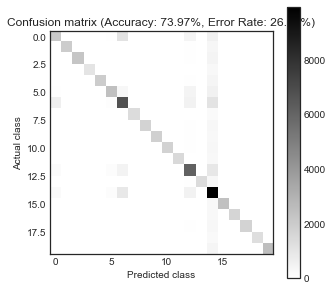

In [104]:
plt.style.use('seaborn-white')
model=RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)
class_rep = classification_report(y_test, model.predict(X_test))
print("Random forest",class_rep)
plt.figure(figsize=(5,5)) 
plot_cm(y_test, model.predict(X_test))
plt.show();

Random forest               precision    recall  f1-score   support

         0.0       0.84      0.78      0.81      4585
         1.0       0.79      0.85      0.82      4497

    accuracy                           0.81      9082
   macro avg       0.82      0.81      0.81      9082
weighted avg       0.82      0.81      0.81      9082



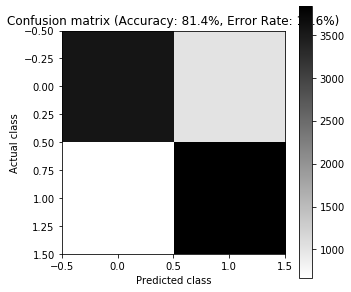

After Covid-19:
0.6023336909870844
Random forest               precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      2733
         1.0       0.76      0.93      0.84      2695

    accuracy                           0.82      5428
   macro avg       0.84      0.82      0.82      5428
weighted avg       0.84      0.82      0.82      5428



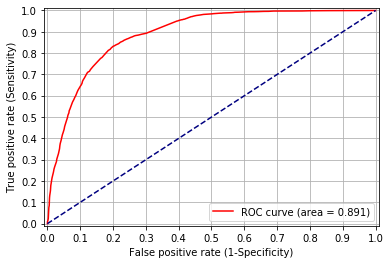

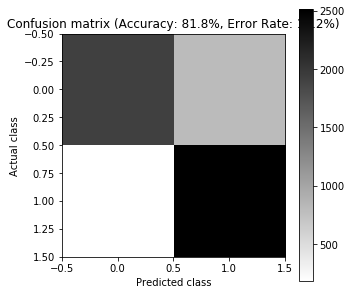

After Covid-19:
0.6150390625000061
Random forest               precision    recall  f1-score   support

         0.0       0.91      0.71      0.80      3107
         1.0       0.76      0.93      0.84      3124

    accuracy                           0.82      6231
   macro avg       0.83      0.82      0.82      6231
weighted avg       0.83      0.82      0.82      6231



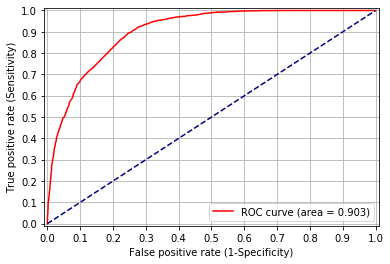

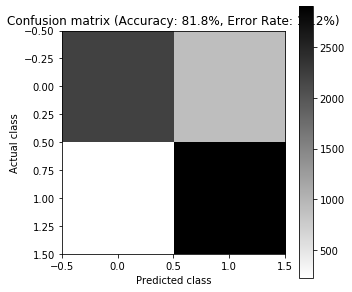

After Covid-19:
0.6467803030303192
Random forest               precision    recall  f1-score   support

         0.0       0.93      0.73      0.81      1547
         1.0       0.77      0.94      0.85      1526

    accuracy                           0.83      3073
   macro avg       0.85      0.83      0.83      3073
weighted avg       0.85      0.83      0.83      3073



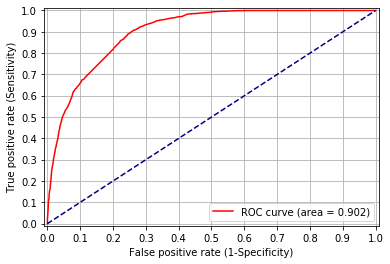

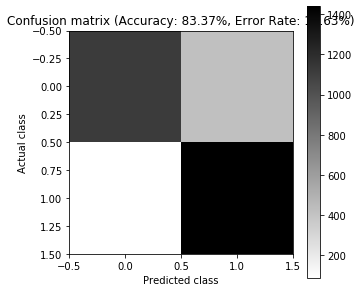

After Covid-19:
0.5764285714285665
Random forest               precision    recall  f1-score   support

         0.0       0.92      0.69      0.79      2676
         1.0       0.75      0.94      0.84      2668

    accuracy                           0.81      5344
   macro avg       0.84      0.82      0.81      5344
weighted avg       0.84      0.81      0.81      5344



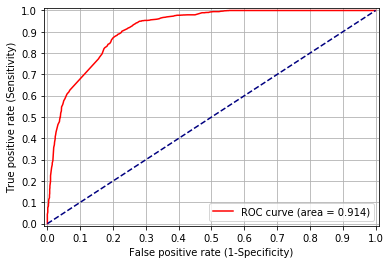

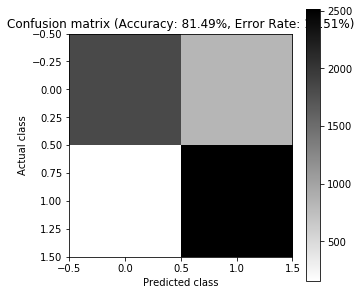

After Covid-19:
0.5888918067227246
Random forest               precision    recall  f1-score   support

         0.0       0.78      0.83      0.81      3934
         1.0       0.83      0.78      0.80      4092

    accuracy                           0.80      8026
   macro avg       0.81      0.81      0.80      8026
weighted avg       0.81      0.80      0.80      8026



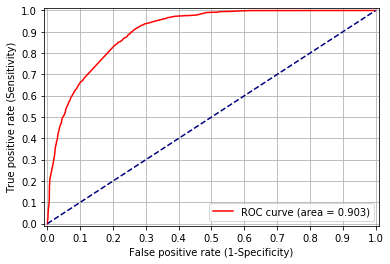

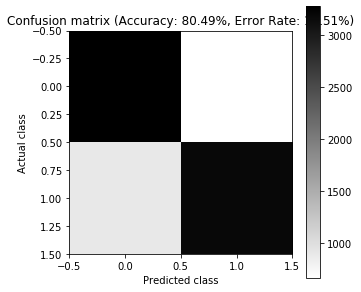

After Covid-19:
0.6258882428939833
Random forest               precision    recall  f1-score   support

         0.0       0.86      0.79      0.82      9283
         1.0       0.80      0.88      0.84      9229

    accuracy                           0.83     18512
   macro avg       0.83      0.83      0.83     18512
weighted avg       0.83      0.83      0.83     18512



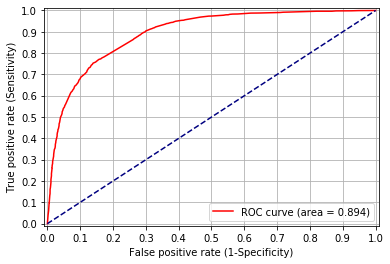

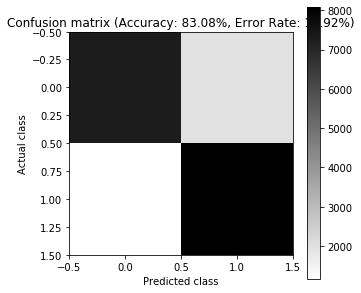

After Covid-19:
0.6570060483870833
Random forest               precision    recall  f1-score   support

         0.0       0.95      0.72      0.82      1695
         1.0       0.77      0.96      0.86      1685

    accuracy                           0.84      3380
   macro avg       0.86      0.84      0.84      3380
weighted avg       0.86      0.84      0.84      3380



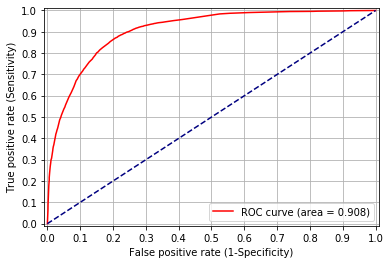

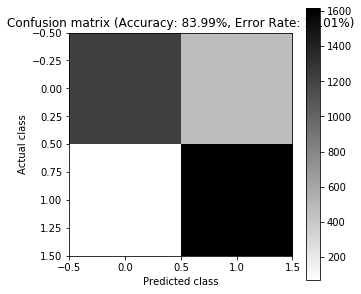

After Covid-19:
0.6917148362235493
Random forest               precision    recall  f1-score   support

         0.0       0.90      0.65      0.75      2333
         1.0       0.72      0.93      0.81      2261

    accuracy                           0.78      4594
   macro avg       0.81      0.79      0.78      4594
weighted avg       0.81      0.78      0.78      4594



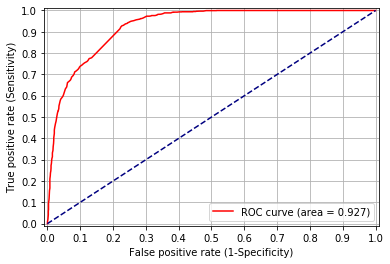

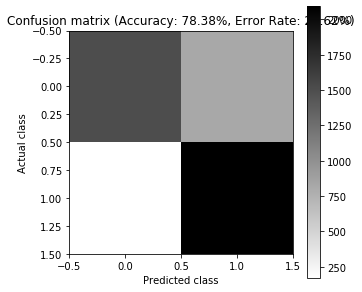

After Covid-19:
0.683223684210564
Random forest               precision    recall  f1-score   support

         0.0       0.91      0.71      0.79      2349
         1.0       0.76      0.93      0.84      2403

    accuracy                           0.82      4752
   macro avg       0.83      0.82      0.82      4752
weighted avg       0.83      0.82      0.82      4752



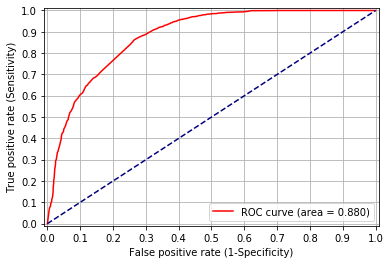

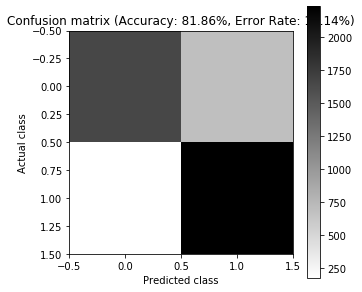

After Covid-19:
0.7934782608694068


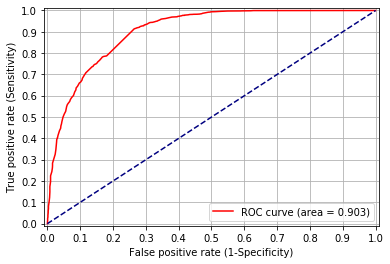

In [15]:
drv_before = driving_style_before
drv_after = driving_style_after
driver_IDs = np.unique(drv_before[:,0])
for driver in driver_IDs:    
    drv = drv_before[drv_before[:,0]==driver]
    drv[:,0] = 1
    other = drv_before[drv_before[:,0]!=driver]
    select = np.random.choice(other.shape[0],size=drv.shape[0],replace=False)
    sub_other = other[select,:]
    sub_other[:,0] = 0
    dataSet = np.vstack ((drv,sub_other))
    X_train, X_test, y_train, y_test = train_test_split(dataSet[:,1:], dataSet[:,0], test_size=0.33)
    model=RandomForestClassifier(n_estimators=200)
    model.fit(X_train, y_train)
    class_rep = classification_report(y_test, model.predict(X_test))
    print("Random forest",class_rep)
    plt.figure(figsize=(5,5)) 
    plot_cm(y_test, model.predict(X_test))
    plt.show()
    p = model.predict_proba(X_test)[:,1]
    ## Predicted probabilities for the label of 0
    #1-p=logit_classifier.predict_proba(X_test)[:,0]
    tpr=roc_curve(y_test,p)[0] # True Positive rate
    fpr=roc_curve(y_test,p)[1] # False Positive rate
    AUC=auc(tpr,fpr)
    ROC(tpr,fpr,AUC)
    print("After Covid-19:")
    drv = drv_after[drv_after[:,0]==driver]   
    print(sum(model.predict(drv[:,1:])/len(model.predict(drv[:,1:]))));    